In [1]:
import pandas as pd
import numpy as np
#df2 = pd.read_csv("./Training_Dataframes/esken30ktweetswithemotions.csv")


In [2]:
# https://medium.com/swlh/tweet-sentiment-analysis-using-python-for-complete-beginners-4aeb4456040
# Turning all Tweets into Vectors for later Machine learning
from sklearn.feature_extraction.text import CountVectorizer
def turnTweetsIntoVector(dataframe,max_features_IN = None):
    dataframe.drop(["Unnamed: 0"],axis = 1, inplace = True)
    keyString = dataframe.keys()
    keyString += "Input"
    dataframe.columns = keyString
    listOfTweets = dataframe["editedInput"].tolist()
    docs = np.array(listOfTweets)
    cv=CountVectorizer(max_features = max_features_IN, binary = True)
    oneHotCv = cv.fit_transform(docs)
    oneHotArray = oneHotCv.toarray()
    oneHotArray.shape
    oneHotDf = pd.DataFrame(oneHotArray)
    #Naming the Columns accordingly for humans to read    
    oneHotDf.columns = cv.get_feature_names()
    #print(oneHotDf.head())
    #print(oneHotDf.info())
    #Normalizing Emotions    
    longDf = pd.concat([dataframe,oneHotDf], axis = 1)
    #dir(CountVectorizer)
    #print(longDf.describe())
    #longDf.head()
    for emotion in longDf[longDf.keys()[12:20]]:
        longDf[emotion] = np.where(longDf[emotion]>=1, 1, 0)
    
    # ----- To check output
    
    #proving, that all words in the tweet are marked appropriatly
    #print(longDf.iloc[0]["editedInput"])
    #print(longDf.iloc[0][longDf.iloc[0]["editedInput"].split()])
    #Shows that keys[0:24] are tweet data, thats not part of the NLP
    #print(longDf.keys()[:27])
    #print(longDf.keys()[:24])
    # -----

    return longDf

In [3]:
#This is already part of old code
import re

def clean(text):
    text = re.sub(r'@[A-Za-z0-9]+\s?', '', text) #Removed Mentions
    text = re.sub(r'#', '', text) #Removed #
    text = re.sub(r'(.)1+', r'1', text) #cleaned single letters
    text = re.sub('((www.[^s]+)|(https?://[^s]+))','',text) #Removes links
    text = re.sub('@','',text) #Remove @
    text = re.sub('-','',text) #Remove -
    text = re.sub('ä','ae',text) #Remove ä
    text = re.sub('Ä','Ae',text) #Remove Ä
    text = re.sub('ö','oe',text) #Remove Ä
    text = re.sub('Ö','Oe',text) #Remove Ä
    text = re.sub('ü','ue',text) #Remove Ä
    text = re.sub('Ü','Ue',text) #Remove Ä
    return text

import nltk
from nltk.stem import PorterStemmer
porter = PorterStemmer()
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

In [4]:
def sentence_toVec(sentence,goalDF):
    #Preparing Input text
    cleanSentence = sentence.lower()
    cleanSentence = clean(cleanSentence)
    cleansentene = stemming_on_text(cleanSentence)
    
    #Preparing EmptyDF
    emptyList = [0]*len(goalDF.keys())
    #print(emptyList)
    #print("Len EmptyList: " + str(len(emptyList)))
    #emptyDF = goalDF.iloc[0:0].copy()
    #emptyDF = emptyDF.append(emptyList)
    #emptyDF = emptyDF.append(pd.DataFrame(emptyList, columns = goalDF.keys()), ignore_index = True)
    emptyDF = pd.DataFrame(columns = goalDF.keys())
    #emptyDF.append(pd.Series(), ignore_index = True)
    emptyDF.loc[len(emptyDF)] = emptyList
    #print(emptyDF)
    #emptyDF = pd.DataFrame(emptyList, columns = goalDF.keys())
    #print("LenEmpty DF: " + str(len(emptyDF)) + " Len Keys Empty DF: " + str(len(emptyDF.keys())))
    
    emptyDF["textInput"][0] = sentence
    emptyDF["editedInput"][0] = cleanSentence
    #keys = list(emptyDF.keys()[0:10])
    #print("---")
    #print("New LenEmpty DF: " + str(len(emptyDF)) + " Len Keys Empty DF: " + str(len(emptyDF.keys())))
    #print(emptyDF["textInput"].tolist())
    listOfWords = cleanSentence.split()
    for word in listOfWords:
        if word in emptyDF.columns:
            emptyDF[word][0] = 1
    emptyDF.fillna(0)
    return emptyDF

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def generateHeatMap(y_test,y_pred, emotion):
    y_pred = y_pred.astype(np.int32)
    """
    print("len(y_test) :" + str(len((y_test))))
    print("max(y_test) :" + str(max((y_test))))
    print("----")
    print("(y_test) :\n" + str((y_test)))
    print("(y_pred) :\n" + str((y_pred)))
    print("----")
    print("type(y_pred) :" + str(type(y_pred)))
    cf_matrix[0][0]: 718
    This is in the cf_matrix: 
    [[718  39]
     [129  14]]
    """
    cf_matrix = confusion_matrix(y_test,y_pred)
    #print("type(cf_matrix[0]): " + str(type(cf_matrix[0])))
    #print("cf_matrix[0][0]: " + str(cf_matrix[0][0]))
    #print("This is in the cf_matrix: \n" + str(cf_matrix))
    true_false = cf_matrix[0][0] #correctly Identified false
    false_positive = cf_matrix[0][1] #predicted true but was false
    false_negative = cf_matrix[1][0] #predicted false but was true
    true_positive = cf_matrix[1][1] #correctly identified true
    
    sumOfAllValues = true_false + false_positive + false_negative + true_positive
    
    accuracy = (true_positive+true_false)/sumOfAllValues
    precision = true_positive / (true_positive + true_false)
    recall = true_positive / (true_positive+false_negative)
    f1_score = 2 / ((1/recall)+(1/precision))
    
    print("----")
    print("With an Accuracy of: "+ str(round(accuracy*100,2)) + " % --- (Perfect at 100%, Failure at 0%)")
    print("With a Precision of: "+ str(round(precision*100,2))+ " % --- (Perfect at 100%, Failure at 0%)")
    print("With a Recall of: "+ str(round(recall*100,2))+ " % --- (Perfect at 100%, Failure at 0%)")
    print("With a f1-Score of: "+ str(round(f1_score*100,2))+ " % --- (Perfect at 100%, Failure at 0%)")
    print("----")

    
    ax = sns.heatmap(cf_matrix, annot = True, cmap = "Blues")
    #print("this is the emotion:" + str(emotion))
    ax.set_title("Seaborn Confusion Matrix for Emotion: {}\n\n".format(str(emotion)))
    ax.set_xlabel("\nPredictedValues")
    ax.set_ylabel("Actual Values")
    
    ax.xaxis.set_ticklabels(["False","True"])
    ax.yaxis.set_ticklabels(["False","True"])
    plt.show()

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
#print(list((keys)))
def trainEmotionModels(dataFrame, train_sizeIN = 0.1, showHeatmap = False):
    tweet_features = dataFrame.keys()[24:]
    x_trainingData = dataFrame[tweet_features]
    #print("x_trainingData: \n" + str(x_trainingData.head()))
    keys = list(dataFrame.keys()[12:20])
    listOfModels = []
    iterator = 0
    for emotion in dataFrame[keys]:
        print("This is the model for the emotion '"+ emotion[:-5] + "': ")
        #print(dataFrame[emotion].head())
        y_emotion = dataFrame[emotion]
        #print("y_emotion.head(): \n" + str(type(y_emotion)))
        x_train, x_test, y_train, y_test = train_test_split(x_trainingData, y_emotion,train_size = train_sizeIN, test_size = 1-train_sizeIN, random_state = 4,shuffle=True)
        #print("Early max(y_test) " + str(max(y_test)))
        #print("type(x_train): "+ str(type(x_train)))
        #print("type(y_train): "+ str(type(y_train)))
        #print("type(x_test): "+ str(type(x_test)))
        #print("type(y_test): "+ str(type(y_test)))
        emotion_Model = DecisionTreeRegressor(random_state = 1)
        emotion_Model.fit(x_train,y_train)
        val_predictions = emotion_Model.predict(x_test)
        listOfModels.append(emotion_Model)
        #print(emotion_Model.predict(x_test.head()))
        #print(y_test.head())
        #print("len(y_test.keys()): " + str(len(y_test.keys())))
        #print("Key Examples: " + str(y_test.keys()[:-15]))
        print("Mean Absolute error for {}: ".format(emotion[:-5]) + str(round(mean_absolute_error(y_test,val_predictions)*100,2))+"%\n")
        #print("type(x_train): " + str(type(x_train)))
        #print("type(dfSentence): " + str(type(dfOfSentence)))
        #print("Predicition for for x_train.head() for emotion {}: ".format(emotion[:-5])+ str(emotion_Model.predict(x_train.head())))
        #print("Predicition for '{}' for emotion {}: ".format(myPrivateSentence,emotion[:-5])+ str(emotion_Model.predict(dfOfSentence[tweet_features])))
        #y_emotionGoal = dataFrame[emotion]
        if(showHeatmap):
            #print("type(y_test): " + str(type(y_test)) + " Content: " + str(y_test))
            #print("type(val_predictions): " + str(type(val_predictions)) + " Content: "+ str(val_predictions))
            generateHeatMap(y_test,val_predictions,emotion[:-5])
        #print("+++++\n")
        
    dicOfModels = {"Wut-Model":listOfModels[0],"Vorfreude-Model":listOfModels[1],"Ekel-Model":listOfModels[2],"Furcht-Model":listOfModels[3],"Freude-Model":listOfModels[4],"Traurigkeit-Model":listOfModels[5], "Ueberraschungs-Model":listOfModels[6],"Vetrauen-Model":listOfModels[7]}
    return dicOfModels

In [7]:
def getAttributesOfTweet(tweetNumber, df):
    keys = list(df.keys()[12:20])
    print("---\nTweet \n--- \n" + df["textInput"][tweetNumber]+"\n--- \nhas these Emotions according to DataInput Tweet:")
    for emotion in df[keys]:
        print(str(emotion[:-5]) + "-Value: " +str(df[emotion][tweetNumber]))

In [8]:
def interpretOwnSentence(sentence, dicOfModels, df):
    if(type(sentence) != str):
        print("Sentence-Parameter is not a String")
        return
    if(type(dicOfModels) != dict):
        print("dicOfModels-Parameter is not a dictionary")
        return
    if(len(dicOfModels)!=8):
        print("dicOfModels Length is not 8")
        return
        
    #Transforming Sentence into Vector
    dfOfSentence = sentence_toVec(sentence, df)
    #print("----\nThis is the shape of the df: \n" + str(dfOfSentence) + "\n----")
    listOfIndex = dfOfSentence.columns[(dfOfSentence == 1).all()].tolist()
    listOfIndex.extend(["textInput","editedInput","WutInput"])
    #print("----\nInput Sentence was transformed to this vector: \n" +str(dfOfSentence.head()))
    keys = list(df.keys()[12:20])
    #Applying different Models to sentence
    keyOfFeatures = dfOfSentence.keys()[24:]
    features = dfOfSentence[keyOfFeatures]    
    iterator = 0
    for model in dicOfModels:
        #print(str(model) + " is the following type: " + str(type(model)))
        result = dicOfModels[model].predict(features)
        #print("---\nThis is the result of {}: ".format(str(model)) + str(result))
        #print("result[0]: " + str(result[0]))
        #print("before writing: " + str(dfOfSentence[dfOfSentence.keys()[12+iterator]]))
        #dfOfSentence[12+iterator] = result[0]
        dfOfSentence[dfOfSentence.keys()[12+iterator]][0] = result[0]
        #print(dfOfSentence[dfOfSentence.keys()[12+iterator]][0])
        #print("---\nThis is in the dfOfSentence: " + str(dfOfSentence[12+iterator][0]))
        if(dfOfSentence[dfOfSentence.keys()[12+iterator]][0]>1):
            dfOfSentence[dfOfSentence.keys()[12+iterator]][0] = 1
        iterator = iterator + 1
    #print("---\nThis is what all the Attributes look like: \n" + str(dfOfSentence[dfOfSentence.keys()[12:20]]))
    getAttributesOfTweet(0,dfOfSentence)

In [9]:
#https://dibyendudeb.com/comparing-machine-learning-algorithms/

#Importing basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Importing sklearn modules
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn import ensemble, linear_model, neighbors, svm, tree, neural_network
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import svm,model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor



def testDifferenModels(dataFrame, number_emotion = 8, train_sizeIN = 0.66):
    if(number_emotion>8 | number_emotion<1):
        number_emotion = 8
    
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))
    models.append(("DTR", DecisionTreeRegressor()))
    
    tweet_features = dataFrame.keys()[24:]
    x_trainingData = dataFrame[tweet_features]
    #print("x_trainingData: \n" + str(x_trainingData.head()))
    lastEmotion = 12+number_emotion
    keys = list(dataFrame.keys()[12:lastEmotion])
    listOfModels = []
    iterator = 0
    for emotion in dataFrame[keys]:
        print(emotion[:-5] + ": ")
        #print(dataFrame[emotion].head())
        y_emotion = dataFrame[emotion]
        #print("y_emotion.head(): \n" + str(type(y_emotion)))
        x_train, x_test, y_train, y_test = train_test_split(x_trainingData, y_emotion,train_size = train_sizeIN, test_size = 1-train_sizeIN, random_state = 4,shuffle=True)
        # evaluate each model in turn
        results = []
        names = []
        scoring = 'accuracy'
        seed = 3
        for name, model in models:
            kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle = True)
            cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
            results.append(cv_results)
            names.append(name)
            msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
            print(msg)
        # boxplot algorithm comparison
        fig = plt.figure()
        fig.suptitle('Comparison between different MLAs for emotion: {}'.format(str(emotion[:-5])))
        ax = fig.add_subplot(111)
        plt.boxplot(results)
        ax.set_xticklabels(names)
        plt.show()
            

In [10]:
#if you want to do it by hand - else use doItAll()
"""
df_esken = pd.read_csv("./Training_Dataframes/esken30ktweetswithemotions.csv")
df_scholz = pd.read_csv("./EmotionCSV.csv")

smallSample_esken = df_esken.iloc[:5000].copy()
print(len(smallSample_esken))
print(len(df_scholz))
mixedDF = pd.concat([df_scholz,smallSample_esken])
mixedDF.reset_index(inplace = True)
print(len(mixedDF))
"""
#vectorizedDataframe_Mixed = turnTweetsIntoVector(df_scholz)
#print(vectorizedDataframe_Mixed.keys()[0:26])
#vectorizedDataframe_Mixed = vectorizedDataframe_Mixed.drop(columns = ["indexInput"])
#print(vectorizedDataframe_Mixed.keys()[0:26])
#giveMeMyModels = trainEmotionModels(vectorizedDataframe_Mixed,True)

'\ndf_esken = pd.read_csv("./Training_Dataframes/esken30ktweetswithemotions.csv")\ndf_scholz = pd.read_csv("./EmotionCSV.csv")\n\nsmallSample_esken = df_esken.iloc[:5000].copy()\nprint(len(smallSample_esken))\nprint(len(df_scholz))\nmixedDF = pd.concat([df_scholz,smallSample_esken])\nmixedDF.reset_index(inplace = True)\nprint(len(mixedDF))\n'

In [11]:
def doItAll(path, sizeDF = 0, train_sizeIn = 0.1, plotGraph = True, ):
    sampleDF = pd.read_csv(path)
    if (sizeDF != 0):
        sampleDF = sampleDF.head(sizeDF)
    if(len(sampleDF)>5000):
        vectorizedDataframe = turnTweetsIntoVector(sampleDF, 5000)
    else:
        vectorizedDataframe = turnTweetsIntoVector(sampleDF)
    model = trainEmotionModels(vectorizedDataframe, train_sizeIn, plotGraph)
    return model, vectorizedDataframe
   

In [12]:
#myModel, vectorizedDataframe = doItAll("./EmotionCSV.csv")

In [13]:
#interpretOwnSentence("spd sieg freude glückwunsch!", myModel, vectorizedDataframe)

This is the model for the emotion 'Wut': 
Mean Absolute error for Wut: 6.41%

----
With an Accuracy of: 93.59 % --- (Perfect at 100%, Failure at 0%)
With a Precision of: 9.18 % --- (Perfect at 100%, Failure at 0%)
With a Recall of: 63.48 % --- (Perfect at 100%, Failure at 0%)
With a f1-Score of: 16.04 % --- (Perfect at 100%, Failure at 0%)
----


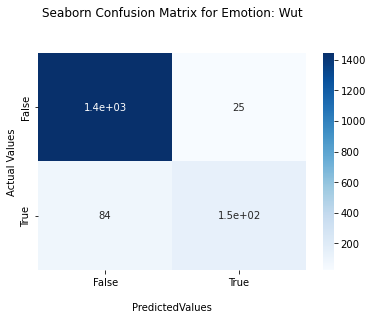

This is the model for the emotion 'Vorfreude': 
Mean Absolute error for Vorfreude: 4.0%

----
With an Accuracy of: 96.0 % --- (Perfect at 100%, Failure at 0%)
With a Precision of: 16.61 % --- (Perfect at 100%, Failure at 0%)
With a Recall of: 83.38 % --- (Perfect at 100%, Failure at 0%)
With a f1-Score of: 27.7 % --- (Perfect at 100%, Failure at 0%)
----


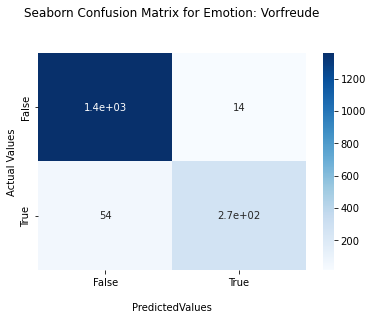

This is the model for the emotion 'Ekel': 
Mean Absolute error for Ekel: 4.41%

----
With an Accuracy of: 95.59 % --- (Perfect at 100%, Failure at 0%)
With a Precision of: 5.05 % --- (Perfect at 100%, Failure at 0%)
With a Recall of: 57.34 % --- (Perfect at 100%, Failure at 0%)
With a f1-Score of: 9.28 % --- (Perfect at 100%, Failure at 0%)
----


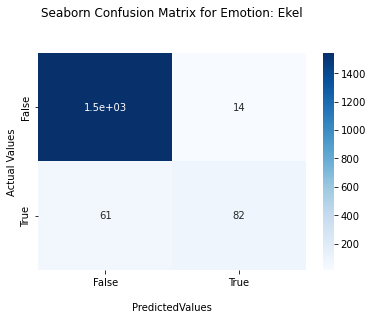

This is the model for the emotion 'Furcht': 
Mean Absolute error for Furcht: 6.76%

----
With an Accuracy of: 93.24 % --- (Perfect at 100%, Failure at 0%)
With a Precision of: 13.25 % --- (Perfect at 100%, Failure at 0%)
With a Recall of: 70.47 % --- (Perfect at 100%, Failure at 0%)
With a f1-Score of: 22.3 % --- (Perfect at 100%, Failure at 0%)
----


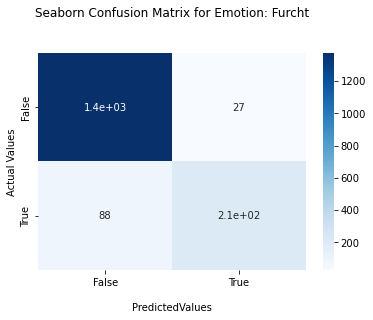

This is the model for the emotion 'Freude': 
Mean Absolute error for Freude: 3.53%

----
With an Accuracy of: 96.47 % --- (Perfect at 100%, Failure at 0%)
With a Precision of: 16.16 % --- (Perfect at 100%, Failure at 0%)
With a Recall of: 84.13 % --- (Perfect at 100%, Failure at 0%)
With a f1-Score of: 27.11 % --- (Perfect at 100%, Failure at 0%)
----


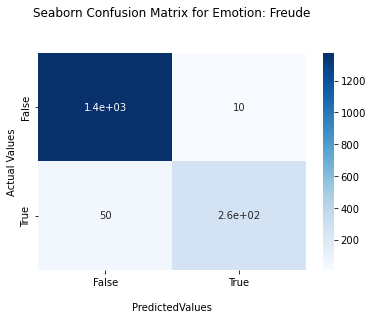

This is the model for the emotion 'Traurigkeit': 
Mean Absolute error for Traurigkeit: 5.12%

----
With an Accuracy of: 94.88 % --- (Perfect at 100%, Failure at 0%)
With a Precision of: 8.74 % --- (Perfect at 100%, Failure at 0%)
With a Recall of: 64.98 % --- (Perfect at 100%, Failure at 0%)
With a f1-Score of: 15.41 % --- (Perfect at 100%, Failure at 0%)
----


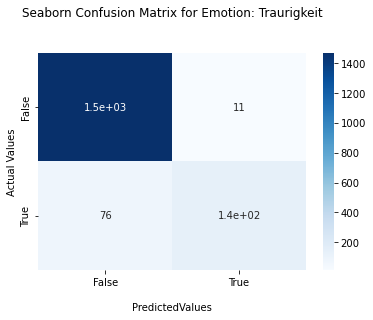

This is the model for the emotion 'Ueberraschung': 
Mean Absolute error for Ueberraschung: 2.59%

----
With an Accuracy of: 97.41 % --- (Perfect at 100%, Failure at 0%)
With a Precision of: 6.52 % --- (Perfect at 100%, Failure at 0%)
With a Recall of: 73.97 % --- (Perfect at 100%, Failure at 0%)
With a f1-Score of: 11.99 % --- (Perfect at 100%, Failure at 0%)
----


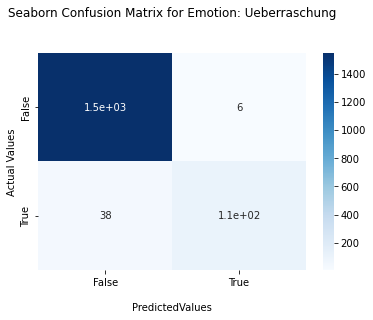

This is the model for the emotion 'Vertrauen': 
Mean Absolute error for Vertrauen: 7.12%

----
With an Accuracy of: 92.88 % --- (Perfect at 100%, Failure at 0%)
With a Precision of: 29.45 % --- (Perfect at 100%, Failure at 0%)
With a Recall of: 83.04 % --- (Perfect at 100%, Failure at 0%)
With a f1-Score of: 43.48 % --- (Perfect at 100%, Failure at 0%)
----


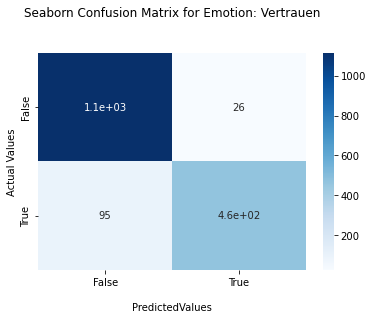

In [14]:
myModel, vectorizedDataframe  = doItAll("./Training_Dataframes/esken30ktweetswithemotions.csv", sizeDF = 5000, train_sizeIn = 0.66, plotGraph = True)

In [15]:
quickModel, quickvectorizedDataframe  = doItAll("./Training_Dataframes/esken30ktweetswithemotions.csv", sizeDF = 1000, train_sizeIn = 0.1, plotGraph = False)

This is the model for the emotion 'Wut': 
Mean Absolute error for Wut: 18.67%

This is the model for the emotion 'Vorfreude': 
Mean Absolute error for Vorfreude: 20.89%

This is the model for the emotion 'Ekel': 
Mean Absolute error for Ekel: 13.11%

This is the model for the emotion 'Furcht': 
Mean Absolute error for Furcht: 21.0%

This is the model for the emotion 'Freude': 
Mean Absolute error for Freude: 21.67%

This is the model for the emotion 'Traurigkeit': 
Mean Absolute error for Traurigkeit: 15.44%

This is the model for the emotion 'Ueberraschung': 
Mean Absolute error for Ueberraschung: 9.44%

This is the model for the emotion 'Vertrauen': 
Mean Absolute error for Vertrauen: 33.0%



Wut: 
LR: 0.850000 (0.047649)
LDA: 0.696970 (0.066391)
KNN: 0.845455 (0.042207)
CART: 0.871212 (0.034049)
NB: 0.709091 (0.046847)
SVM: 0.845455 (0.042207)
DTR: 0.863636 (0.033195)


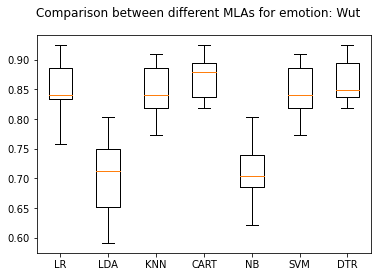

In [16]:
testDifferenModels(quickvectorizedDataframe, number_emotion = 1, train_sizeIN = 0.66)

In [17]:
#Testing Model for fun!
#print(type(df_esken["text"][0:5]))
#for tweet in df_esken["text"][0:5]:
#    interpretOwnSentence(tweet,myModel,vectorizedDataframe)
interpretOwnSentence("gruen umwelt klima streik frauen krach kriegsieg freude glückwunsch unglück freiheit gerechtigkeit!", myModel, vectorizedDataframe)

---
Tweet 
--- 
gruen umwelt klima streik frauen krach kriegsieg freude glückwunsch unglück freiheit gerechtigkeit!
--- 
has these Emotions according to DataInput Tweet:
Wut-Value: 0.0
Vorfreude-Value: 0.0
Ekel-Value: 0.0
Furcht-Value: 0.0
Freude-Value: 1.0
Traurigkeit-Value: 0.0
Ueberraschung-Value: 0.0
Vertrauen-Value: 1.0


In [43]:
# Export model for streamlit application

#import pickle

#filename = 'finalized_model.sav'
#pickle.dump(myModel, open(filename, 'wb'))

In [44]:
#loaded_model = pickle.load(open(filename, 'rb'))

#Testing Model for fun!
#print(type(df_esken["text"][0:5]))
#for tweet in df_esken["text"][0:5]:
#    interpretOwnSentence(tweet,myModel,vectorizedDataframe)
interpretOwnSentence("gruen umwelt klima streik frauen krach kriegsieg freude glückwunsch unglück freiheit gerechtigkeit!", loaded_model, vectorizedDataframe)

---
Tweet 
--- 
gruen umwelt klima streik frauen krach kriegsieg freude glückwunsch unglück freiheit gerechtigkeit!
--- 
has these Emotions according to DataInput Tweet:
Wut-Value: 0.0
Vorfreude-Value: 0.0
Ekel-Value: 0.0
Furcht-Value: 0.0
Freude-Value: 1.0
Traurigkeit-Value: 0.0
Ueberraschung-Value: 0.0
Vertrauen-Value: 1.0
